In [7]:
import os
import glob

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
import sklearn.metrics

import utils

from skl_dataset import SKLSwingDataset, oversample_minority

from sklearn.metrics import confusion_matrix
import seaborn as sn

In [8]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [9]:
path = "data/"
use_oversampling = True


shot_types = ["left", "straight", "right"]
n_shot_types = len(shot_types) + 1

In [10]:
X_data, y_data = utils.load_data(path)

In [11]:
X_data.shape

(110, 6, 500)

In [12]:
if use_oversampling:
    X_data, y_data = oversample_minority(X_data, y_data)
    print(X_data.shape, y_data.shape)


n = X_data.shape[0]

# GENERATE DATA SPLITS
train = 0.75
val = 0.2
test = 0.05

X_train = X_data[:int(n*train),:,:] 
y_train = y_data[:int(n*train),:]

X_val = X_data[int(n*train):int(n*(val+train)),:,:]
y_val = y_data[int(n*train):int(n*(val+train)),:]

X_test = X_data[-int(n*test):,:,:]
y_test = y_data[-int(n*test):,:]

# /GENERATE DATA SPLITS

(225, 6, 500) (225, 10)


In [13]:
train_set = SKLSwingDataset(X_train, y_train, augment = True, oversample=True)
val_set = SKLSwingDataset(X_val, y_val, mean=train_set.mean, std=train_set.std, y_mean=train_set.y_dist_mean, y_std=train_set.y_dist_std)
test_set = SKLSwingDataset(X_test, y_test, mean=train_set.mean, std=train_set.std, y_mean=train_set.y_dist_mean, y_std=train_set.y_dist_std)


In [14]:
np.save("norm_data/X_mean.npy", train_set.mean)
np.save("norm_data/X_std.npy", train_set.std)
np.save("norm_data/y_mean.npy", train_set.y_dist_mean)
np.save("norm_data/y_std.npy", train_set.y_dist_std)

In [15]:
train_set.mean == np.load("norm_data/X_mean.npy")

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

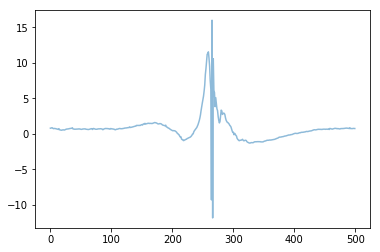

In [16]:
# Plot X_data
plt.plot(train_set.X_data[0][0],alpha=0.5)


In [17]:
#Training data
X_train = train_set.X_data
y_train = train_set.y_data

train_classes = [row[:-1] for row in y_train]
y_train = np.argmax(train_classes, axis=1)

for i in range(len(y_train)):
    y_train[i] = y_train[i] // n_shot_types


#Reshape training data
n, nx, ny = X_train.shape
X_train = X_train.reshape((n,nx*ny))
  
    
#Test data    
X_test = test_set.X_data
y_test = test_set.y_data



#Reshape test data
n, nx, ny = X_test.shape
X_test = X_test.reshape((n,nx*ny))

test_classes = [row[:-1] for row in y_test]
y_test = np.argmax(test_classes, axis=1)

for i in range(len(y_test)):
    y_test[i] = y_test[i] // n_shot_types

        

In [18]:
X_train.shape

(198, 3000)

In [19]:
#One-vs-one SVM with rbf kernel.
rbfsvm = svm.SVC(kernel='rbf', decision_function_shape='ovo',
                   gamma=1, C=1, probability=True).fit(X_train, y_train)
   
       

In [20]:
def print_predictions(predictions, truth, labels, n=10):
    for i in range(len(predictions)):
        p = predictions[i]
        t = truth[i]
        nLabels = len(labels)
        if i < n:
            if p >= 0 and p < nLabels:
                print("Predicted shot type is " + str(labels[p]))
                print("Real shot type is " + str(labels[t]) + "\n\n")
                
            else:
                print("Invalid shot class")
            
        else:
            return


def calcAccuracy(predictions, truth):
    numPreds = len(predictions)
    p = 0
     
    for i in range(numPreds):
        if predictions[i] == truth[i]:
            p += 1
      
    return p/numPreds
    


In [21]:
predictions = rbfsvm.predict(X_test)
accuracy = calcAccuracy(predictions, y_test)

print ("Accuracy is %f (%f" % (accuracy, accuracy * 100) + "%)")

print_predictions(predictions, y_test, shot_types, 10)

Accuracy is 0.818182 (81.818182%)
Predicted shot type is straight
Real shot type is straight


Predicted shot type is left
Real shot type is left


Predicted shot type is straight
Real shot type is right


Predicted shot type is straight
Real shot type is straight


Predicted shot type is straight
Real shot type is left


Predicted shot type is left
Real shot type is left


Predicted shot type is left
Real shot type is left


Predicted shot type is straight
Real shot type is straight


Predicted shot type is left
Real shot type is left


Predicted shot type is left
Real shot type is left




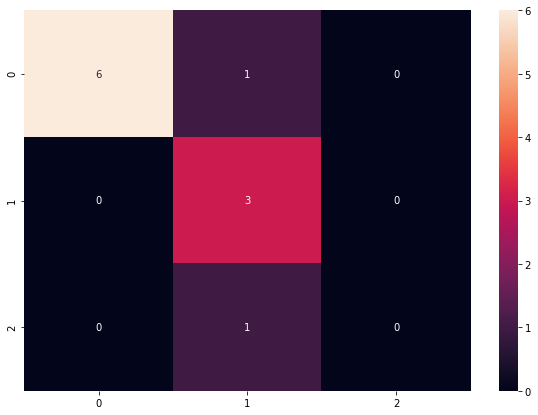

In [22]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
